## First, import the libraries we will use

In [25]:
%matplotlib inline

import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Open the GOES-16 NetCDF File
Using xarray, I assign the opened file to the variable C for the CONUS domain.

In [26]:
#FILE = 'OR_ABI-L2-MCMIPC-M3_G16_s20182831437203_e20182831439576_c20182831440087.nc'
FILE = 'C:/data/satellite/OR_ABI-L2-MCMIPC-M6_G16_s20191272001267_e20191272004040_c20191272004152.nc'
C = xarray.open_dataset(FILE)

## Date and Time Information
Each file represents the data collected during one scan sequence for the domain. There are several different time stamps in this file, which are also found in the file's name.

In [27]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : %s' % scan_start)
print('Scan midpoint : %s' % scan_mid)
print('Scan End      : %s' % scan_end)
print('File Created  : %s' % file_created)
print('Scan Duration : %.2f minutes' % ((scan_end-scan_start).seconds/60))

Scan Start    : 2019-05-07 20:01:26.700000
Scan midpoint : 2019-05-07 20:02:45.300000
Scan End      : 2019-05-07 20:04:04
File Created  : 2019-05-07 20:04:15.200000
Scan Duration : 2.62 minutes


## Water Vapor RGB Recipe
Color images are a Red-Green-Blue (RGB) composite of three different channels. The Water Vapor RGB product is made of a channel difference for each RGB value. We will assign the following channels as our RGB values, according the the [GOES Quick Guide Reference](http://rammb.cira.colostate.edu/training/visit/quick_guides/Simple_Water_Vapor_RGB.pdf):


|          -    | **RED**      | **GREEN**      | **BLUE**     |
|---------------|:------------:|:--------------:|:------------:|
| **Description**| Cloud top or surface temperature | Upper level water vapor | Lower level water vapor |
| **Wavelength**| 10.3 &#181;m inverted| 6.2 &#181;m inverted  | 7.3 (inverted) &#181;m inverted |
| **Channel**   |     13     |    8        |      10    |
| **Units**     | Temperature (K) | Temperature (K) | Temperature (K) |
| **Range of Values**| 5.81 to -70.86 Celsius | -30.48 to -58.49 Celsius | -12.12 to -28.03 |
| **Gamma Correction**| none | none | none |

Since RGB values must be between 0 and 1, we normalize the Red channel between the recommended range of values. Also, the gammea correction is used to control the brightness of the image where `corrected_value = value^(1/gamma)`, but no correction is made for this product (gamma is 1). 

The multiband formatted file we loaded is convenient becuase all the GOES channels are in the same NetCDF file. Next, we will assign our variables R, G, and B as the data for each channel.

In [28]:
# Confirm that each band is the wavelength we are interested in
for band in [13, 8, 10]:
    print("%s is %.2f %s (units: %s)" %
                (C['band_wavelength_C%02d' % band].long_name,
                 C['band_wavelength_C%02d' % band][0],
                 C['band_wavelength_C%02d' % band].units,
                 C['CMI_C%02d' % band].units))

ABI band 13 central wavelength is 10.33 um (units: K)
ABI band 8 central wavelength is 6.17 um (units: K)
ABI band 10 central wavelength is 7.34 um (units: K)


In [29]:
# Load the three channels into appropriate R, G, and B variables
R = C['CMI_C13'].data-273.15 # remember to invert and convert to Celsius
G = C['CMI_C08'].data-273.15 # remember to invert and convert to Celsius
B = C['CMI_C10'].data-273.15 # remember to invert and convert to Celsius

In [30]:
# Normalize each channel by the appropriate range of values. e.g. R = (R-minimum)/(maximum-minimum)
R = (R--70.86)/(5.81--70.86)
G = (G--58.49)/(-30.48--58.49)
B = (B--28.03)/(-12.12--28.03)

# Invert the colors
R = 1-R
G = 1-G
B = 1-B

# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

# The final RGB array :)
RGB = np.dstack([R, G, B])

## Simple Image
Use `plt.imshow` to get a quick look at the channels and RGB composite we created.

First, we plot each channel individually. The deeper the color means the satellite is observing more light in that channel. You will notice the hot spot in the red channel in the middle of the western United States.

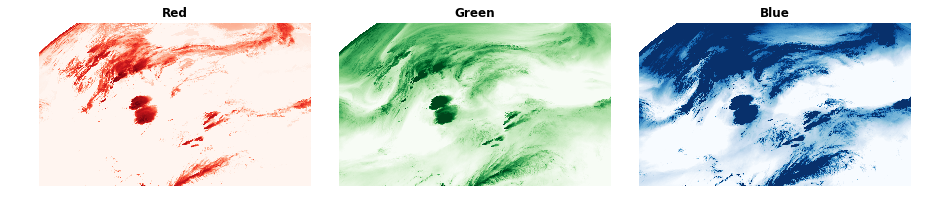

In [31]:
fig, ([ax1, ax2, ax3]) = plt.subplots(1, 3, figsize=(16,3))

ax1.imshow(R, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='semibold')
ax1.axis('off');

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('Green', fontweight='semibold')
ax2.axis('off');

ax3.imshow(B, cmap='Blues', vmax=1, vmin=0)
ax3.set_title('Blue', fontweight='semibold')
ax3.axis('off');

plt.subplots_adjust(wspace=.02)

The addition of the three channels results in a color image. We combine the three channels in a stacked array and display the image with `imshow` again. Again, notice the hot spots in the west. Also notice that it is nighttime in the east.

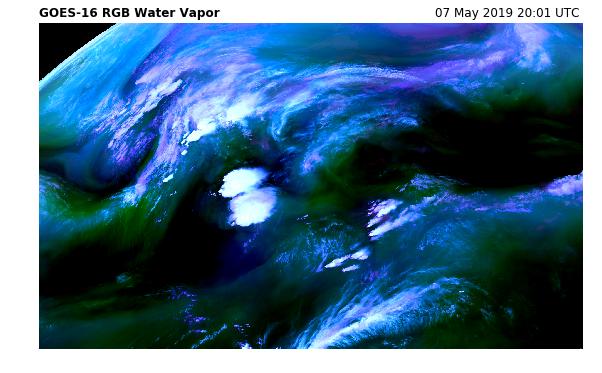

In [32]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))

# The RGB using the raw veggie band
ax1.imshow(RGB)
ax1.set_title('GOES-16 RGB Water Vapor', fontweight='semibold', loc='left', fontsize=12);
ax1.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax1.axis('off');

In [33]:
C['goes_imager_projection']

<xarray.DataArray 'goes_imager_projection' ()>
array(-2147483647)
Coordinates:
    t        datetime64[ns] 2019-05-07T20:02:45.367022976
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x

In [34]:
# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
# See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

The geostationary projection is the easiest way to plot the image on a map. Essentially, we are stretching the image across a map with the same projection and dimensions as the data.

#### The magic function: `pyproj.Proj`
This function creates a map projection object of the geostationary projection.

In [35]:
# Create a pyproj geostationary map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Perform cartographic transformation. That is, convert image projection coordinates (x and y)
# to latitude and longitude values.
XX, YY = np.meshgrid(x, y)
lons, lats = p(XX, YY, inverse=True)

In the above image, you see a black area in the upper left corner where the value is `nan`. Since these pixels displaying outer space do not have coordinates on the globe, `pyproj.Proj` assigns these points a value 1e30. We will assign the latitude and longitude of these pixels as an arbitrary location in the Gulf of Alaska, a point that will not overlap the other data points. We do this becuase `pcolormesh` needs to know the latitude and longitude of every pixel and the x and y value cannot contain nans or masked values. Thus `pcolormesh` will stretch the black pixels in the corner of our GOES-16 image to converge on the coordinates 57 North and 152 West. The image will not display correctly without this step.

In [36]:
# Assign the pixels showing space as a single point in the Gulf of Alaska
lats[np.isnan(R)] = 57
lons[np.isnan(R)] = -152

 ## Plot with `Basemap`: Lambert Conformal Projection
 I am going to project the GOES-16 data on a Lambert Conformal Projection.

In [37]:
# Make a new map object Lambert Conformal projection
mL = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=3000*3000, height=2500*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

We can't simply plot the re-projected image with `imshow` because the pixels are spaced irregularly. We must use `pcolormesh`. Plotting RGB images with `pcolormesh` is not intuitive, but it possible. We need to create a flattened array of a color tuple for each pixel and assign it as the color. Details on doing this are on Stack Overflow [here](https://stackoverflow.com/questions/29232439/plotting-an-irregularly-spaced-rgb-image-in-python) and [here](https://stackoverflow.com/questions/41389335/how-to-plot-geolocated-rgb-data-faster-using-python-basemap). Below is my method.

In [38]:
# Create a color tuple for pcolormesh

# Don't use the last column of the RGB array or else the image will be scrambled!
# This is the strange nature of pcolormesh.
rgb = RGB[:,:-1,:]

# Flatten the array, becuase that's what pcolormesh wants.
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3)

# Adding an alpha channel will plot faster, according to Stack Overflow. Not sure why.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

Now we can plot the GOES data on the new projection using pcolormesh

C:\Users\tjtur\Anaconda3\lib\site-packages\matplotlib\colors.py:259: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
C:\Users\tjtur\Anaconda3\lib\site-packages\matplotlib\colors.py:259: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


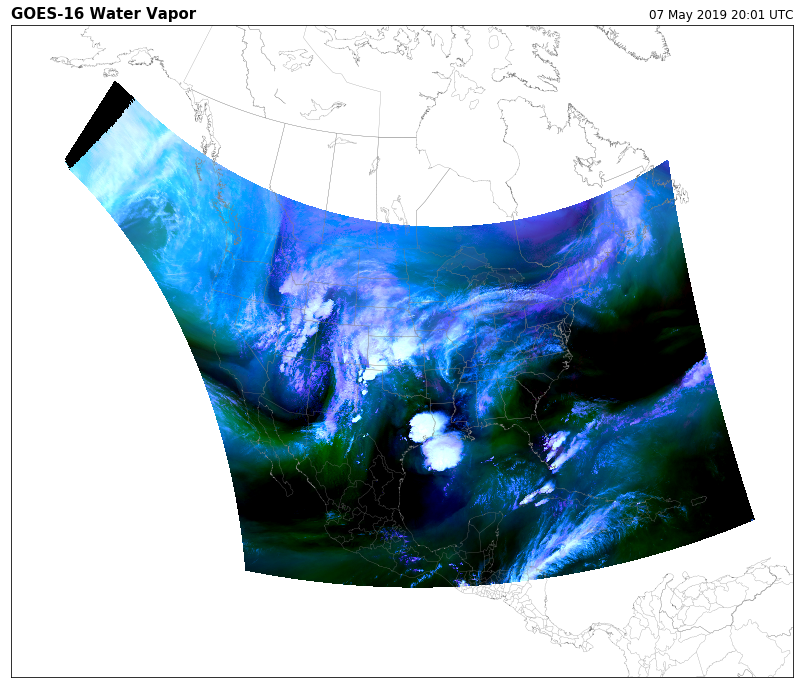

In [39]:
plt.figure(figsize=[15, 12])

# We need an array the shape of the data, so use R. The color of each pixel will be set by color=colorTuple.
newmap = mL.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # Without this line the RGB colorTuple is ignored and only R is plotted.

mL.drawcoastlines(linewidth=.25, color='grey')
mL.drawcountries(linewidth=.25, color='grey')
mL.drawstates(linewidth=.25, color='grey')

plt.title('GOES-16 Water Vapor', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC'), loc='right');

 ## Plot with `Basemap`: Cylindrical Projection
 It is often useful to zoom on a specific location. This image will zoom in on Utah.

In [43]:
# Location of MI
l = {'latitude': 42.0,
     'longitude': -90}

add_degs = 7.00

# Draw zoomed map
mZ = Basemap(resolution='i', projection='cyl', area_thresh=50000,\
             llcrnrlon=l['longitude']-add_degs, llcrnrlat=l['latitude']-add_degs,\
             urcrnrlon=l['longitude']+add_degs, urcrnrlat=l['latitude']+add_degs,)

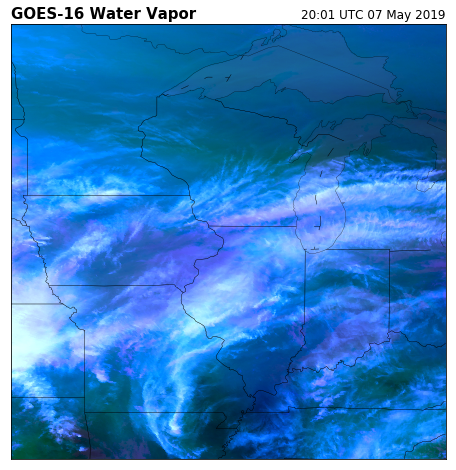

In [44]:
# Now we can plot the GOES data on a zoomed in map centered over Utah.
plt.figure(figsize=[8, 8])

newmap = mZ.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)

mZ.drawcoastlines(linewidth=.25)
mZ.drawcountries(linewidth=.25)
mZ.drawstates(linewidth=.25)

plt.title('GOES-16 Water Vapor', loc='left', fontweight='semibold', fontsize=15);
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right');